In [177]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


import plotly.offline as py 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [178]:
americaOrigin = pd.read_csv("Bank_of_America_data.csv")
target = americaOrigin['BAD']
america_cat_or = americaOrigin.iloc[:,[7,8,10,4,5]]

In [179]:
americaOrigin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
BAD        5960 non-null int64
LOAN       5960 non-null int64
MORTDUE    5442 non-null float64
VALUE      5848 non-null float64
REASON     5708 non-null object
JOB        5681 non-null object
YOJ        5445 non-null float64
DEROG      5252 non-null float64
DELINQ     5380 non-null float64
CLAGE      5652 non-null float64
NINQ       5450 non-null float64
CLNO       5738 non-null float64
DEBTINC    4693 non-null float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [208]:
'JOB' not in americaOrigin.columns

False

In [209]:
def QualiQuantiDecomposition(data):
    data_cat = data.select_dtypes(include=['object'])
    data_num = data._get_numeric_data()
    dictEnc = {}
    var_categs = []
    
    data_cat_imputed = data_cat.apply(lambda x: x.fillna(x.value_counts().index[0]))
    
#     data_cat_imputed = data_cat.apply(lambda x: x.fillna("Unknown"))

    for col in data_cat.columns:
        le = LabelEncoder()
        varLE = le.fit_transform(data_cat_imputed[col])
        dictEnc[col] = le
        var_categs.append(pd.DataFrame(varLE))
    
    data_cat_LE = pd.concat(var_categs, axis=1)
    ohe = OneHotEncoder()
    data_cat_OH = ohe.fit_transform(data_cat_LE)
    dictEnc['onehot'] = ohe
        
#     le = LabelEncoder()
#     jobLE = le.fit_transform(data_cat_imputed['JOB'])
#     dictEnc['job'] = le
#     le2 = LabelEncoder()
#     reasonLE = le2.fit_transform(data_cat_imputed['REASON'])
#     dictEnc['reason'] = le2
#     data_cat_LE = pd.concat([pd.DataFrame(reasonLE),pd.DataFrame(jobLE)], axis=1)
#     ohe = OneHotEncoder()
#     data_cat_OH = ohe.fit_transform(data_cat_LE)
#     dictEnc['onehot'] = ohe

    
#     for col in data_cat:
#         onehot = pd.get_dummies(data_cat[col])
#         data_cat = data_cat.drop(col,axis = 1)
#         data_cat = data_cat.join(onehot)
    
    data_discrete = data_num[['DEROG', 'DELINQ', 'NINQ']]
    
    data_discrete_interpolated = data_discrete.interpolate()
    
    data_cat = pd.concat([data_discrete_interpolated, pd.DataFrame(data_cat_OH.toarray())], axis=1)
    
    data_num.drop(['DEROG', 'DELINQ', 'NINQ'], axis=1, inplace = True)    
        
    for col in data_num: 
        cols = []
        qmn = data_num[col].quantile(q=0.25)
        qmx = data_num[col].quantile(q=0.75)
        data_num[col] = data_num[col].apply(lambda x : qmn if x < qmn else (qmx if x > qmx else x))
        
    return data_num, data_cat, dictEnc

In [210]:
america_num_or, america_cat, dictEnc = QualiQuantiDecomposition(americaOrigin.drop('BAD', axis=1))

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



In [200]:
def fillNAN(data, method):
    if method == "mean":
        return data.fillna(data.mean())
    elif method == "median":
        return data.fillna(data.median())
    else:
        return "error"

In [201]:
fillNAN(america_num_or, "median").head()

,LOAN,MORTDUE,VALUE,YOJ,CLAGE,CLNO,DEBTINC
0,11100.0,46276.0,66075.5,10.5,115.116702,15.0,34.818262
1,11100.0,70053.0,68400.0,7.0,121.833333,15.0,34.818262
2,11100.0,46276.0,66075.5,4.0,149.466667,15.0,34.818262
3,11100.0,65019.0,89235.5,7.0,173.466667,20.0,34.818262
4,11100.0,91488.0,112000.0,3.0,115.116702,15.0,34.818262


In [202]:
# america_num = fillNAN(america_num_or, "mean")

In [203]:
nans = []
for i in america_num.columns:
    nans.append([i,len(america_num[i][america_num[i].isna()])])
print(nans)

[['LOAN', 0], ['MORTDUE', 0], ['VALUE', 0], ['YOJ', 0], ['CLAGE', 0], ['DEBTINC', 0]]


C:\Users\USER\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning:

JointGrid annotation is deprecated and will be removed in a future release.



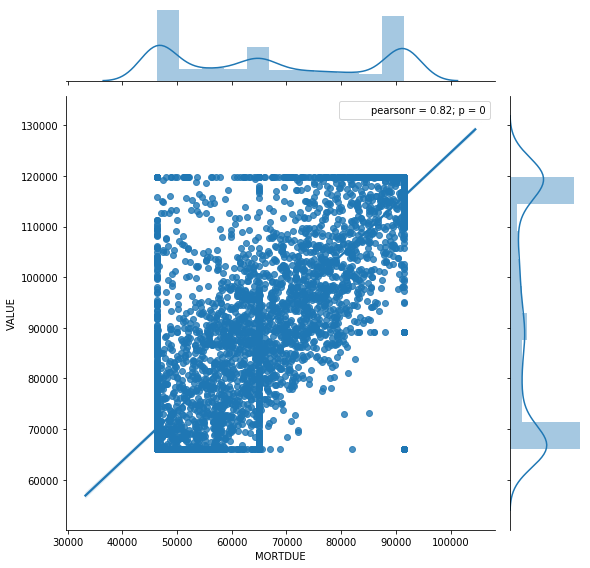

In [204]:
import scipy.stats as stats
r1 = sns.jointplot(x="MORTDUE",y="VALUE", data=america_num, kind="reg", height=8)
r1.annotate(stats.pearsonr)
plt.show()

### JOIN DATA 

In [205]:
america_joined = pd.concat([america_num, america_cat], axis=1)

# Classification 

## KNN 

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(america_joined, target, random_state=0)

In [15]:
from sklearn.neighbors import KNeighborsClassifier


In [16]:
error = []
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn_model = knn.fit(X_train, y_train)
    pred_i = knn_model.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Erreur')

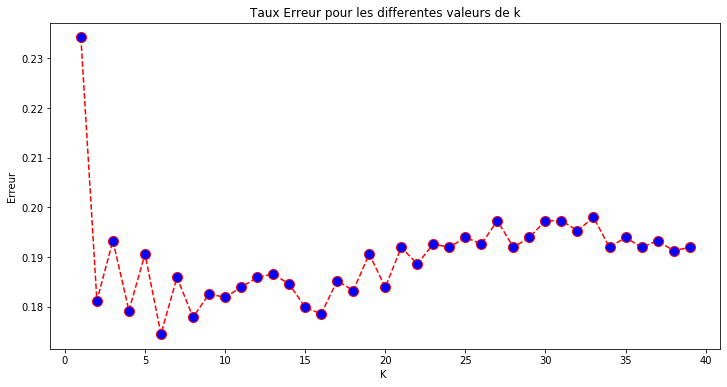

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Taux Erreur pour les differentes valeurs de k')
plt.xlabel('K ')
plt.ylabel('Erreur')

### On choisit 6 

In [18]:
knn = KNeighborsClassifier(n_neighbors=6)
knn_model = knn.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

In [19]:
knn.score(X_test, y_test)

0.825503355704698

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1194
           1       0.74      0.19      0.30       296

    accuracy                           0.83      1490
   macro avg       0.78      0.59      0.60      1490
weighted avg       0.81      0.83      0.78      1490



# Feature Selection 

In [21]:
from sklearn.feature_selection import chi2, SelectKBest, f_classif


### Correlation between Categorical variables and Target 

In [22]:
amerCat2 = america_cat

In [23]:
chi2(america_cat[['DEROG', 'DELINQ', 'NINQ']].dropna(), target)
# X_new = SelectKBest(chi2, k=2).fit_transform(america_cat_or['NINQ'], target)

(array([1075.70672406, 1806.77439124,  409.07364279]),
 array([6.29423743e-236, 0.00000000e+000, 5.83137798e-091]))

In [24]:
from sklearn import preprocessing

def QualiQuantiDecompositionLE(data):
    data_cat = data.select_dtypes(include=['object'])
    data_num = data._get_numeric_data()
    
    data_cat_imputed = data_cat.apply(lambda x: x.fillna(x.value_counts().index[0]))
    
#     data_cat_imputed = data_cat.apply(lambda x: x.fillna("Unknown"))
    
    le = preprocessing.LabelEncoder()
    job = le.fit_transform(data_cat_imputed['JOB'])
    data_cat_imputed = data_cat_imputed.drop('JOB',axis = 1)
    data_cat_imputed = pd.concat([data_cat_imputed, pd.DataFrame(job)], axis=1)
    data_cat_imputed.rename(columns = {0 : 'JOB'}, inplace=True)
#     data_cat_imputed = data_cat_imputed.join(pd.DataFrame(job))
    reason = le.fit_transform(data_cat_imputed['REASON'])
    data_cat_imputed = data_cat_imputed.drop('REASON',axis = 1)
    data_cat_imputed = pd.concat([data_cat_imputed, pd.DataFrame(reason)], axis=1)
#     data_cat_imputed = data_cat_imputed.join(pd.DataFrame(reason))
    
    data_cat_imputed.rename(columns = {0 : 'REASON'}, inplace= True)
    
    data_discrete = data_num[['DEROG', 'DELINQ', 'NINQ']]
    
    data_discrete_interpolated = data_discrete.interpolate()
    
    data_cat = pd.concat([data_discrete_interpolated, data_cat_imputed], axis=1)
    
    data_num.drop(['DEROG', 'DELINQ', 'NINQ'], axis=1, inplace = True)    
        
    for col in data_num: 
        cols = []
        qmn = data_num[col].quantile(q=0.25)
        qmx = data_num[col].quantile(q=0.75)
        data_num[col] = data_num[col].apply(lambda x : qmn if x < qmn else (qmx if x > qmx else x))
        
    return data_num, data_cat

In [25]:
datanum, datacat2 = QualiQuantiDecompositionLE(americaOrigin)

## Teste de Chi2 sur les variables Quantitatives et Target 

In [26]:
ch2 = chi2(datacat2, target)
# X_new = SelectKBest(chi2, k=2).fit_transform(america_cat_or['NINQ'], target)

([<matplotlib.axis.XTick at 0x1aa3e086470>,
 <a list of 5 Text xticklabel objects>)

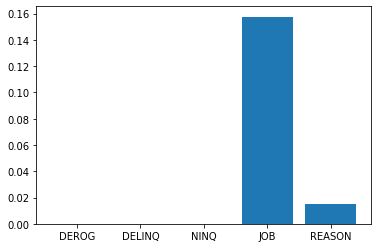

In [27]:
x = np.arange(0,5)
plt.bar(x , ch2[1])
plt.xticks(x, datacat2.columns)

### la variable Job n'est pas corrélée donc on la supprime

## Teste ANOVA sur les variables Qualitatives et Target 

In [28]:
anovaTest = f_classif(america_num, target)
anovaTest

(array([ 54.5636847 ,  30.94152177,  23.28617463,  16.68236589,
        185.55764979,   0.26321967,  29.20957464]),
 array([1.71158828e-13, 2.77491441e-08, 1.43078490e-06, 4.47692374e-05,
        1.24000696e-41, 6.07935801e-01, 6.74798083e-08]))

([<matplotlib.axis.XTick at 0x1aa3e0c5198>,
 <a list of 7 Text xticklabel objects>)

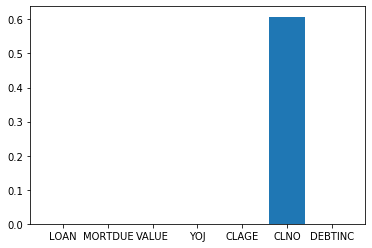

In [29]:
x = np.arange(0,7)
plt.bar(x , anovaTest[1])
plt.xticks(x, america_num.columns)

## Tau de Kendall 

In [30]:
america_num.shape

(5960, 7)

In [31]:
from scipy import stats
pvalues = []
cols = []
for i in america_num.columns:
    tau, p_value = stats.kendalltau(america_num[i], target)
    pvalues.append(p_value)
    cols.append(i)


([<matplotlib.axis.XTick at 0x1aa3e1314e0>,
 <a list of 7 Text xticklabel objects>)

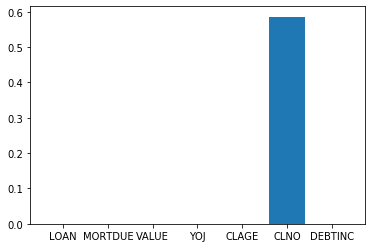

In [32]:
x = np.arange(0,7)
plt.bar(x , pvalues)
plt.xticks(x, cols)

### CLNO n'est pas corrélée avec la variable cible donc on supprime CLNO 

In [212]:
america_num, america_cat, dict_Enc = QualiQuantiDecomposition(americaOrigin.drop(['BAD', 'CLNO', 'JOB'], axis=1))
america_num_or = america_num

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



In [213]:
america_num = fillNAN(america_num_or, "median")

C:\Users\USER\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning:

JointGrid annotation is deprecated and will be removed in a future release.



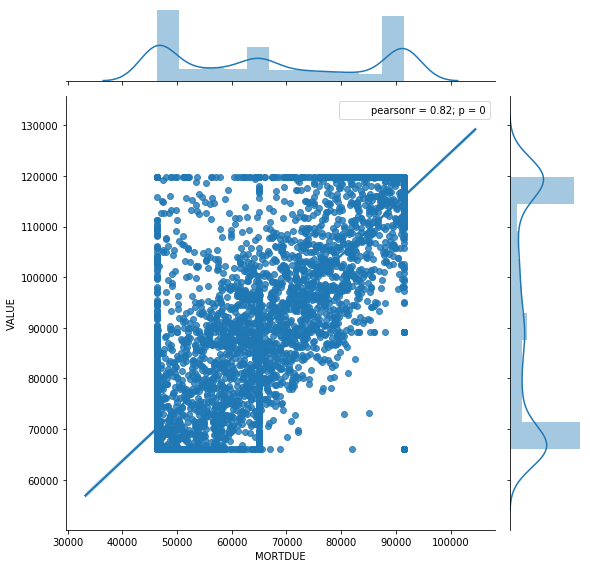

In [214]:
import scipy.stats as stats
r1 = sns.jointplot(x="MORTDUE",y="VALUE", data=america_num, kind="reg", height=8)
r1.annotate(stats.pearsonr)
plt.show()

In [215]:
america_joined = pd.concat([america_num, america_cat], axis=1)
X_train, X_test, y_train, y_test = train_test_split(america_joined, target, random_state=0)

In [216]:
america_joined.head()

,LOAN,MORTDUE,VALUE,YOJ,CLAGE,DEBTINC,DEROG,DELINQ,NINQ,0,1
0,11100.0,46276.0,66075.5,10.5,115.116702,34.818262,0.0,0.0,1.0,0.0,1.0
1,11100.0,70053.0,68400.0,7.0,121.833333,34.818262,0.0,2.0,0.0,0.0,1.0
2,11100.0,46276.0,66075.5,4.0,149.466667,34.818262,0.0,0.0,1.0,0.0,1.0
3,11100.0,65019.0,89235.5,7.0,173.466667,34.818262,0.0,0.0,0.5,1.0,0.0
4,11100.0,91488.0,112000.0,3.0,115.116702,34.818262,0.0,0.0,0.0,0.0,1.0


In [217]:
error = []
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn_model = knn.fit(X_train, y_train)
    pred_i = knn_model.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Erreur')

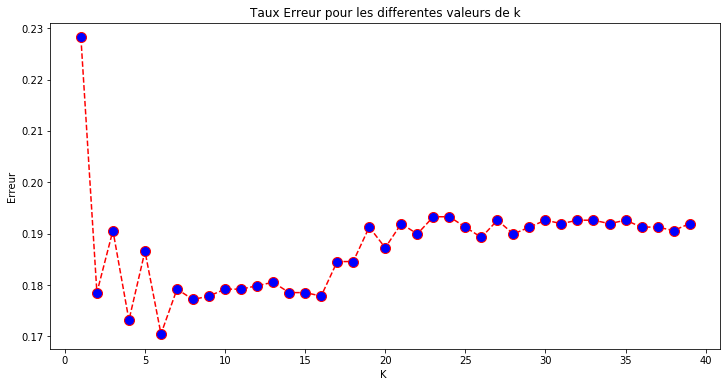

In [218]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Taux Erreur pour les differentes valeurs de k')
plt.xlabel('K ')
plt.ylabel('Erreur')

In [219]:
knn = KNeighborsClassifier(n_neighbors=6)
knn_model = knn.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print(knn.score(X_test, y_test))
print(classification_report(y_test, y_pred_knn))

0.8295302013422818
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1194
           1       0.74      0.22      0.34       296

    accuracy                           0.83      1490
   macro avg       0.79      0.60      0.62      1490
weighted avg       0.82      0.83      0.79      1490



# XGBOOST 

In [220]:
import xgboost as xgb

In [41]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

C:\Users\USER\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



# Do not Touch 

In [94]:
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_l...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
                         'eta': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
                         'gamma': [0.0, 0

In [96]:
yPredGrid = grid.predict(X_test)

In [97]:
print(classification_report(y_test, yPredGrid))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1194
           1       0.83      0.60      0.70       296

    accuracy                           0.90      1490
   macro avg       0.87      0.79      0.82      1490
weighted avg       0.89      0.90      0.89      1490



In [98]:
grid.best_params_

{'colsample_bytree': 0.5,
 'eta': 0.05,
 'gamma': 0.1,
 'max_depth': 10,
 'min_child_weight': 1}

# Continue 

In [221]:
from sklearn.preprocessing import MinMaxScaler
def ScaleMinMax(data_num):
    scaler = MinMaxScaler()
    data_num_sc = pd.DataFrame(scaler.fit_transform(data_num), columns=data_num.columns)
    return data_num_sc
    

In [222]:
from sklearn.preprocessing import StandardScaler
def ScalerStandard(data_num):
    scaler = StandardScaler()
    data_num_sc = pd.DataFrame(scaler.fit_transform(data_num), columns=data_num.columns)
    return data_num_sc
    

In [223]:
america_numstandard = ScalerStandard(america_num)
america_num_minmax = ScaleMinMax(america_num)

In [224]:
america_joined_standard = pd.concat([america_numstandard, america_cat], axis=1)
america_joined_minmax = pd.concat([america_num_minmax, america_cat], axis=1)

### Standard Scaler (Behi)

In [225]:
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(america_joined_standard, target)

### KNN with n=6 

In [226]:
knn = KNeighborsClassifier(n_neighbors=6)
knn_model = knn.fit(X_train_st, y_train_st)
y_pred_knn_st = knn_model.predict(X_test_st)
print(knn.score(X_test_st, y_test_st))
print(classification_report(y_test_st, y_pred_knn_st))

0.8630872483221477
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1181
           1       0.91      0.38      0.53       309

    accuracy                           0.86      1490
   macro avg       0.88      0.68      0.73      1490
weighted avg       0.87      0.86      0.84      1490



{'colsample_bytree': 0.5,
 'eta': 0.05,
 'gamma': 0.4,
 'max_depth': 10,
 'min_child_weight': 1}

### XGBOOST 

In [227]:
D_train_st = xgb.DMatrix(X_train_st, label=y_train_st)
D_test_st = xgb.DMatrix(X_test_st, label=y_test_st)

C:\Users\USER\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



In [228]:
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)
grid.fit(X_train_st, y_train_st)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_l...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=4,
             param_grid={'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
                         'eta': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
                         'gamma': [0.0, 0

In [229]:
yPredGrid_st = grid.predict(X_test_st)
print(classification_report(y_test_st, yPredGrid_st))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1181
           1       0.83      0.64      0.72       309

    accuracy                           0.90      1490
   macro avg       0.87      0.80      0.83      1490
weighted avg       0.89      0.90      0.89      1490



### MinMax Scaler (5ayeb)

### KNN n=3 

### X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(america_joined_minmax, target)

### knn = KNeighborsClassifier(n_neighbors=6)
knn_model = knn.fit(X_train_mm, y_train_mm)
y_pred_knn_mm = knn_model.predict(X_test_mm)
print(knn.score(X_test_mm, y_test_mm))
print(classification_report(y_test_mm, y_pred_knn_mm))

### XGBOOST 

### D_train_mm = xgb.DMatrix(X_train_mm, label=y_train_mm)
D_test_mm = xgb.DMatrix(X_test_mm, label=y_test_mm)

### from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)
grid.fit(X_train_mm, y_train_mm)

### Random Forest Classifier 

In [230]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [231]:
rfc=RandomForestClassifier()

In [232]:
rfc

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [238]:
param_grid_RF = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
    'criterion' :['gini', 'entropy'],
    'min_samples_leaf' : [1, 2, 4],
    'min_samples_split' : [2, 5, 10]
}

In [239]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid_RF, cv= 3)

In [240]:
CV_rfc.fit(X_train_st, y_train_st)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [242]:
yPredGridRF_st = CV_rfc.predict(X_test_st)
print(classification_report(y_test_st, yPredGridRF_st))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1181
           1       0.87      0.59      0.70       309

    accuracy                           0.90      1490
   macro avg       0.89      0.78      0.82      1490
weighted avg       0.89      0.90      0.89      1490



In [243]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 500}